# Deep Learning Course Project - Gesture Recognition

### Problem Statement
- Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

- The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
    - Thumbs Up - Increase the volume.
    - Thumbs Down - Decrease the volume.
    - Left Swipe - 'Jump' backwards 10 seconds.
    - Right Swipe - 'Jump' forward 10 seconds.
    - Stop - Pause the movie.

### Problem Solving:
- <b>Generator:</b> The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

- <b>Model:</b> We will be developing model using different Architecture and understand the performance of the model interms of Accuracy and finalising the model

- <b>Write up: </b> This document should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
### Setting the seed value for the value not to change randomly
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [5]:
## We will be using the cv2 library for the preprocessing steps like the Image read, resize, applying background preprocessing etc
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Importing the libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN, RNN
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from keras.regularizers import l2

In [7]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [8]:
project_folder='/datasets/Project_data'

In [9]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

- We read the folder names for training and validation. We also set the batch_size here.

In [10]:
train_doc = np.random.permutation(open(project_folder+'/train.csv').readlines())
val_doc = np.random.permutation(open(project_folder+'/val.csv').readlines())
batch_size = 64 #experiment with the batch size

##### Lets see some sample image to understand the images provided to us.
We will read all the files in the folder and display the image

In [11]:
sample_image = os.listdir(project_folder+'/train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])


In [12]:
print(sample_image)

['WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17_24_58_Pro_00021.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00025.png', 'WIN_20180926_17_24_58_Pro_00027.png', 'WIN_20180926_17_24_58_Pro_00029.png', 'WIN_20180926_17_24_58_Pro_00031.png', 'WIN_20180926_17_24_58_Pro_00033.png', 'WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00037.png', 'WIN_20180926_17_24_58_Pro_00039.png', 'WIN_20180926_17_24_58_Pro_00041.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58_Pro_00045.png', 'WIN_20180926_17_24_58_Pro_00047.png', 'WIN_20180926_17_24_58_Pro_00049.png', 'WIN_20180926_17_24_58_Pro_00051.png', 'WIN_20180926_17_24_58_Pro_00053.png', 'WIN_20180926_17_24_58_Pro_00055.png', 'WIN_20180926_17_24_58_P

In [13]:
sample_im_path = project_folder+'/train'+'/'+ train_doc[0].split(';')[0]
sample = imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])

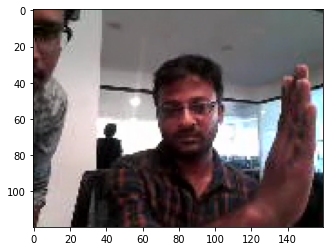

In [14]:
plt.imshow(sample)

In [15]:
sample.shape

(120, 160, 3)

- We will resize the image

In [16]:
image = cv2.resize(sample,(50,50))

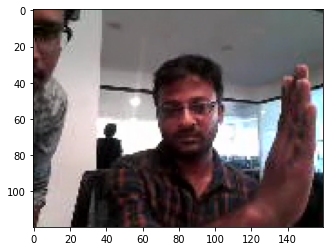

In [17]:
plt.imshow(sample)

- We will convert the color code

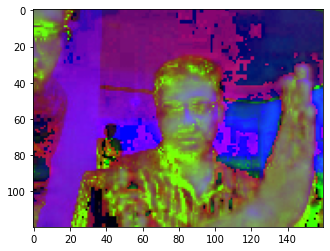

In [18]:
hsv = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)

- We see that lot of other details present other than the hand gesture. Lets try to apply the Skin Mask Mode
    - <b>SkinMask Mode :</b> In this mode, we will first convert the input image to HSV and put range on the H,S,V values based on skin color range. Then apply errosion followed by dilation. Then gaussian blur to smoothen out the noises. Using this output as a mask on original input to mask out everything other than skin colored things. Finally I have grayscaled it. This mode is useful when there is good amount of light and you dont have empty background.

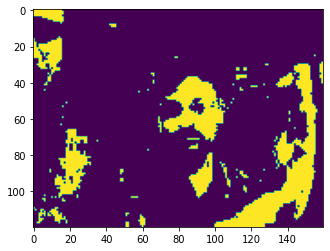

In [19]:
# we will apply the skin color range for asian. The lower and upper range for skin color is mentioned
low_range = np.array([108, 23, 82], dtype = "uint8") 
upper_range = np.array([179, 255, 255], dtype = "uint8")
#Apply skin color range
mask = cv2.inRange(hsv, low_range, upper_range)
plt.imshow(mask)

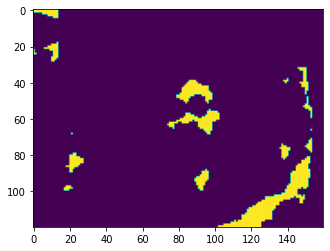

In [20]:
skinkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
mask = cv2.erode(mask, skinkernel, iterations = 1)
plt.imshow(mask)

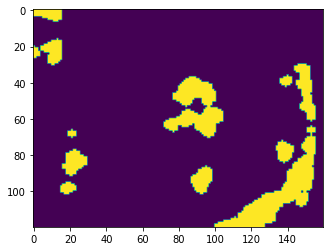

In [21]:
mask = cv2.dilate(mask, skinkernel, iterations = 1)
plt.imshow(mask)

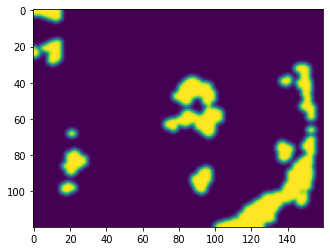

In [22]:
#blur
mask = cv2.GaussianBlur(mask, (15,15), 1)
plt.imshow(mask)

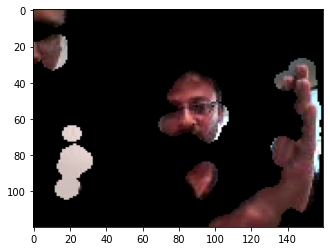

In [23]:
#bitwise and mask original frame
res = cv2.bitwise_and(sample, sample, mask = mask)
plt.imshow(res)

- we are able to mask the background of the person to reduce the noise however, we can see that part of the required information is also getting removed.

- We have seen the different set of the effects it has applied on the image. However, it still reads the faces also few of the hand movements are also getting blurred and removed. Hence we will follow the generator with both the preprocessing with the Skin Mask mode as well as without it. We can understand whether the model will perform well with the Masking the environment or not

<b>Generator</b>

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [24]:
import abc, six
@six.add_metaclass(abc.ABCMeta)
class ModelBuilder():
    
    def initialize_path(self,project_folder):
        #### the Path for the folder path is refered over here
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        # initialisation of the objects are done
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        # The ing_dx is taken with the series of values in the frames to sample value mentioned
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            # read all the images in the folder
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            #  Iterate over the frames/images of a folder to read them in
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                               
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                                                        save_weights_only=False, mode='auto', save_freq= 'epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass        


<b>Model</b>

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

<b>Model Generator</b>

In [25]:
class ModelGenerator(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [26]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model)
    

- Running test for small batch and different frames for initial trial run

image_height=160,image_width=160, frames_to_sample=30,batch_size=30,num_epochs=3

In [27]:
SampleRun_4 = RunFunction(160,160,30,30,3)

The Height, Width, frames, batches, epochs used are: 160 160 30 30 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_____________________________________________________

image_height=120,image_width=120, frames_to_sample=16,batch_size=30,num_epochs=3

In [28]:
SampleRun_14 = RunFunction(120,120,16,30,3)

The Height, Width, frames, batches, epochs used are: 120 120 16 30 3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
___________________________________________________

image_height=100,image_width=100, frames_to_sample=16,batch_size=10,num_epochs=2

In [29]:
SampleRun_26 = RunFunction(100,100,16,10,2)

The Height, Width, frames, batches, epochs used are: 100 100 16 10 2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_9 (Activation)    (None, 8, 50, 50, 32)     0         
___________________________________________________

- We have run the test for the different combinations for the dimensions, frames, batches and epochs. Placed only the best 3 runs because of the length of the file.

# 1- Initial Run with Batchsize 40 and Epochs 15


In [30]:
Run1 = RunFunction(160,160,20,40,15)

The Height, Width, frames, batches, epochs used are: 160 160 20 40 15
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_13 (Activation)   (None, 10, 80, 80, 32)    0         
__________________________________________________

- Model 1 is overfitting.. Performing well in the Training data and not performing well in the Test data
    - Model with 160*160, Frames - 20, Batch 40, Epoch - 15
        - Best Train Accuracy - 97.59 %
        - Best Test Accuracy - 21 %


# 2- Model with the Epochs 25 and Augmentation done

In [31]:
class ModelGenerator(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(512,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)

In [33]:
Run2 = RunFunction(160,160,20,20,25)

The Height, Width, frames, batches, epochs used are: 160 160 20 20 25
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 10, 80, 80, 32)    0         
__________________________________________________

- After 20 Epoch, the Train and the Test difference is less. So lets use more than 25 epochs in all our following run
    - Model with 120*120, Frames - 20, Batch 20, Epoch - 25
        - Best Train Accuracy - 92.91%
        - Best Test Accuracy - 90%
- at 22nd epoch

# 3- Model with the Learning Rate

In [34]:
class ModelGenerator(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (2,2,2), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)

# 4- Model Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [37]:
class ModelGenerator(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    

In [38]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)

In [39]:
Run4 = RunFunction(120,120,16,20,25)

The Height, Width, frames, batches, epochs used are: 120 120 16 20 25
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 16, 120, 120, 16)  64        
__________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 16, Batch 20, Epoch - 25
        - Best Train Accuracy - 92.01%
        - Best Test Accuracy - 92%
- at 22nd epoch

# 5- Model Adding dropout in each convolution layers

In [40]:
class ModelGenerator(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [41]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)

In [42]:
Run5 = RunFunction(120,120,16,20,25)

The Height, Width, frames, batches, epochs used are: 120 120 16 20 25
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 120, 120, 16)  64        
__________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 16, Batch 20, Epoch - 25
        - Best Train Accuracy - 92.38%
        - Best Test Accuracy - 86%

# 6- Model Reducing the number of parameters

In [43]:
class ModelGenerator(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)

In [45]:
Run6 = RunFunction(100,100,16,20,20)

The Height, Width, frames, batches, epochs used are: 100 100 16 20 20
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_40 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_41 (Activation)   (None, 8, 50, 50, 32)     0         
__________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 100*100, Frames - 16, Batch 20, Epoch - 20
        - Best Train Accuracy - 73.91%
        - Best Test Accuracy - 65%

# 7- Model - Reducing the number of parameters again with diff dimension

In [46]:
class ModelGenerator(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [47]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)

In [48]:
Run7 = RunFunction(120,120,16,20,25)

The Height, Width, frames, batches, epochs used are: 120 120 16 20 25
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_44 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_45 (Activation)   (None, 8, 60, 60, 32)     0         
__________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 16, Batch 20, Epoch - 25
        - Best Train Accuracy - 82.43%
        - Best Test Accuracy - 81%

# 8- Model - CNN- LSTM Model


In [49]:
class ModelGenerator(ModelBuilder):

    def define_model(self):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(64))
        model.add(Dropout(0.25))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [50]:
def RunFunction(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    SampleModel=ModelGenerator()
    SampleModel.initialize_path(project_folder)
    SampleModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    SampleModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    SampleModel_model=SampleModel.define_model()
    SampleModel_model.summary()
    print("Total Number of Params:", SampleModel_model.count_params())
    SampleModel.train_model(SampleModel_model,augment_data=True)



In [51]:
Run8 = RunFunction(120,120,18,20,20)

The Height, Width, frames, batches, epochs used are: 120 120 18 20 20
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 18, Batch 20, Epoch - 20
        - Best Train Accuracy - 91.48%
        - Best Test Accuracy - 82%

### Let's apply some data augmentation & check the model performance.

In [52]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                   
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                                     save_weights_only=False, mode='auto', save_freq= 'epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# 9-Model with Augmentation

In [53]:
class Model9(ModelBuilderMoreAugmentation):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [54]:
def RunFunction9(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    RunModel=Model9()
    RunModel.initialize_path(project_folder)
    RunModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    RunModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    RunModel_model=RunModel.define_model()
    RunModel_model.summary()
    print("Total Number of Params:", RunModel_model.count_params())
    RunModel.train_model(RunModel_model,augment_data=True)

In [55]:
Run9 = RunFunction9(160,160,20,20,20)

The Height, Width, frames, batches, epochs used are: 160 160 20 20 20
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_49 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 160*160, Frames - 20, Batch 20, Epoch - 20
        - Best Train Accuracy - 89.52%
        - Best Test Accuracy - 78%

In [56]:
class ModelBuilderMoreAugmentation1(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
                hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                low_range = np.array([108, 23, 82], dtype = "uint8") 
                upper_range = np.array([179, 255, 255], dtype = "uint8")
                #Apply skin color range
                mask = cv2.inRange(hsv, low_range, upper_range)
                skinkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
                mask = cv2.erode(mask, skinkernel, iterations = 1)
                mask = cv2.dilate(mask, skinkernel, iterations = 1)
                mask = cv2.GaussianBlur(mask, (15,15), 1)
                image = cv2.bitwise_and(image, image, mask = mask)


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                    low_range = np.array([108, 23, 82], dtype = "uint8") 
                    upper_range = np.array([179, 255, 255], dtype = "uint8")
                    #Apply skin color range
                    mask = cv2.inRange(hsv, low_range, upper_range)
                    skinkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
                    mask = cv2.erode(mask, skinkernel, iterations = 1)
                    mask = cv2.dilate(mask, skinkernel, iterations = 1)
                    mask = cv2.GaussianBlur(mask, (15,15), 1)
                    image = cv2.bitwise_and(image, image, mask = mask)

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                                     save_weights_only=False, mode='auto', save_freq= 'epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# 10 - Model with Augmentation and Dropouts

In [60]:
class Model11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, (3,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [61]:
def RunFunction11(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:", rheight,ewidth,rframes,rbatchsize,repochs)
    RunModel=Model11()
    RunModel.initialize_path(project_folder)
    RunModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    RunModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    RunModel_model=RunModel.define_model()
    RunModel_model.summary()
    print("Total Number of Params:", RunModel_model.count_params())
    RunModel.train_model(RunModel_model,augment_data=True)

In [62]:
Run11 = RunFunction11(120,120,16,20,25)

The Height, Width, frames, batches, epochs used are: 120 120 16 20 25
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_56 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_56 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_57 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 16, Batch 20, Epoch - 25
        - Best Train Accuracy - 71.12%
        - Best Test Accuracy - 32%
- at 24 epoch

# 11- Model LSTM GRU

In [63]:
class Model12(ModelBuilderMoreAugmentation):
    
    def define_model(self):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(64))
        model.add(Dropout(0.25))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [66]:
def RunFunction12(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:", rheight,ewidth,rframes,rbatchsize,repochs)
    RunModel=Model12()
    RunModel.initialize_path(project_folder)
    RunModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    RunModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    RunModel_model=RunModel.define_model()
    RunModel_model.summary()
    print("Total Number of Params:", RunModel_model.count_params())
    RunModel.train_model(RunModel_model,augment_data=True)

In [67]:
Run12 = RunFunction12(120,120,18,20,20)

The Height, Width, frames, batches, epochs used are: 120 120 18 20 20
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 18, Batch 20, Epoch - 20
        - Best Train Accuracy - 88.69
        - Best Test Accuracy - 82
- at 18th epoch

# 12 - Model Transfer Learning

In [68]:
# We will use mobilenet for our analysis

from keras.applications import mobilenet

In [69]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class Model13(ModelBuilderMoreAugmentation):
    
    def define_model(self):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(64))
        model.add(Dropout(0.25))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [70]:
def RunFunction13(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:", rheight,ewidth,rframes,rbatchsize,repochs)
    RunModel=Model13()
    RunModel.initialize_path(project_folder)
    RunModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    RunModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    RunModel_model=RunModel.define_model()
    RunModel_model.summary()
    print("Total Number of Params:", RunModel_model.count_params())
    RunModel.train_model(RunModel_model,augment_data=True)

In [71]:
Run13 = RunFunction13(120,120,16,5,20)

The Height, Width, frames, batches, epochs used are: 120 120 16 5 20
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
__________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 16, Batch 5, Epoch - 20
        - Best Train Accuracy - 96.53%
        - Best Test Accuracy - 92%
- at 15 epoch

# 13 - Model Transfer Learning GRU


In [75]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class Model15(ModelBuilderMoreAugmentation):
    
    def define_model(self):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(64))
        model.add(Dropout(0.25))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [76]:
def RunFunction15(rheight,ewidth,rframes,rbatchsize,repochs):
    print("The Height, Width, frames, batches, epochs used are:" , rheight,ewidth,rframes,rbatchsize,repochs)
    RunModel=Model15()
    RunModel.initialize_path(project_folder)
    RunModel.initialize_image_properties(image_height=rheight,image_width=ewidth)
    RunModel.initialize_hyperparams(frames_to_sample=rframes,batch_size=rbatchsize,num_epochs=repochs)
    RunModel_model=RunModel.define_model()
    RunModel_model.summary()
    print("Total Number of Params:", RunModel_model.count_params())
    RunModel.train_model(RunModel_model,augment_data=True)

In [77]:
Run15 = RunFunction15(120,120,16,5,20)

The Height, Width, frames, batches, epochs used are: 120 120 16 5 20
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_37 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_38 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_39 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
__________________________________________________

- The difference in the Train and the Test Accuracy reduced after the 16th Epoch.
    - Model with 120*120, Frames - 16, Batch 5, Epoch - 20
        - Best Train Accuracy - 99.02%
        - Best Test Accuracy - 99%
- at 16th epoch

# The best model is the transfer learning with GRU. It has 99% Accuracy in both Train and Test data

# Load Model and Testing

In [78]:
import time
from keras.models import load_model

In [79]:
model= load_model('model_init_2021-08-0122_26_42.637639/model-00017-0.03195-0.99020-0.02197-0.99000.h5')


In [82]:
test_generator = Model15()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g= test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=False)

In [83]:
batch_data, batch_labels= next(g)

In [84]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [86]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[1 0 1 2 4 2 1 3 1 4 1 4 2 4 3 1 0 0 0 4]
